In [ ]:
import os
# Definir la estructura del proyecto
directories = [
    "data/raw",
    "data/processed",
    "data/external",
    "data/interim",

]

# Crear los directorios
for directory in directories:
    os.makedirs(directory, exist_ok=True)
print("Estructura de directorios y archivos creada con √©xito.")


Estructura de directorios y archivos creada con √©xito.


In [ ]:
import os
import requests
import gzip
import shutil

# Definir la URL del archivo y la ruta de destino
url = "https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Software.jsonl.gz"
download_path = "data/raw/Software.jsonl.gz"
extract_path = "data/raw/Software.jsonl"

# Crear el directorio si no existe
os.makedirs(os.path.dirname(download_path), exist_ok=True)

# Descargar el archivo
print("Descargando archivo...")
response = requests.get(url, stream=True)
with open(download_path, "wb") as file:
    shutil.copyfileobj(response.raw, file)
print("Descarga completada.")

# Extraer el archivo .gz
print("Extrayendo archivo...")
with gzip.open(download_path, "rb") as f_in:
    with open(extract_path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
print("Extracci√≥n completada.")

# Opcional: eliminar el archivo comprimido
os.remove(download_path)
print("Archivo comprimido eliminado.")

Descargando archivo...
Descarga completada.
Extrayendo archivo...
Extracci√≥n completada.
Archivo comprimido eliminado.


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count

def create_spark_session():
    """
    Crea una sesi√≥n de Spark.
    """
    return SparkSession.builder.appName("AmazonSoftwareReviews").getOrCreate()

def load_jsonl(file_path, spark):
    """
    Carga el dataset JSONL en un DataFrame de Spark.
    """
    print(f"üì• Cargando datos desde {file_path}...")
    df = spark.read.json(file_path)
    print("‚úÖ Datos cargados correctamente.")
    return df

def explore_data(df):
    """
    Explora la estructura y contenido del dataset.
    """
    print("\nüìå Esquema del dataset:")
    df.printSchema()

    print("\nüìä Cantidad total de registros:")
    print(f"‚úÖ Total de registros: {df.count()}")

    print("\nüîé Verificaci√≥n de valores nulos:")
    df.select([count(col(c)).alias(c) for c in df.columns]).show()

def save_as_parquet(df, output_path):
    """
    Guarda el DataFrame en formato Parquet para mayor eficiencia.
    """
    print(f"\nüíæ Guardando datos en {output_path}...")
    df.write.mode("overwrite").parquet(output_path)
    print("‚úÖ Datos guardados correctamente.")

# if __name__ == "__main__":
# üìå Definir rutas
raw_data_path = "data/raw/Software.jsonl"
interim_data_path = "data/interim/Software_interim.parquet"

#  Crear sesi√≥n de Spark
spark = create_spark_session()

# Cargar datos
df = load_jsonl(raw_data_path, spark)

#  Explorar los datos
explore_data(df)

# Guardar en Parquet
save_as_parquet(df, interim_data_path)

# ‚úÖ Finalizaci√≥n
print("\nüéØ Proceso de ingestion completado.")



üì• Cargando datos desde data/raw/Software.jsonl...
‚úÖ Datos cargados correctamente.

üìå Esquema del dataset:
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)


üìä Cantidad total de registros:
‚úÖ Total de registros: 4880181

üîé Verificaci√≥n de valores nulos:
+-------+------------+-------+-----------+-------+-------+---------+-------+-------+-----------------

In [ ]:
!pip install wordcloud matplotlib


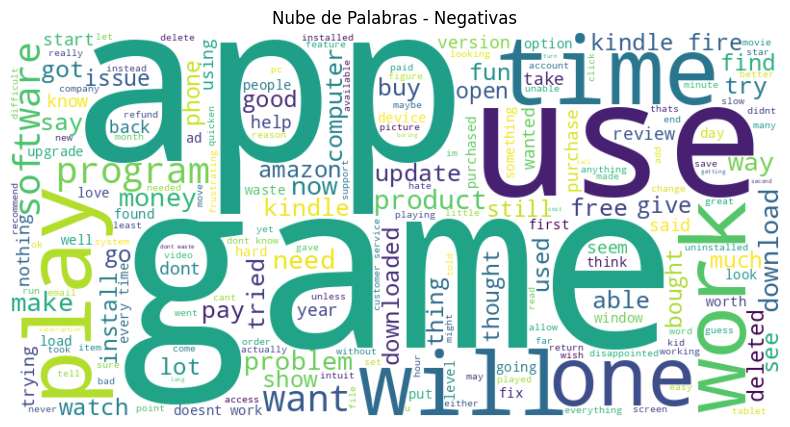

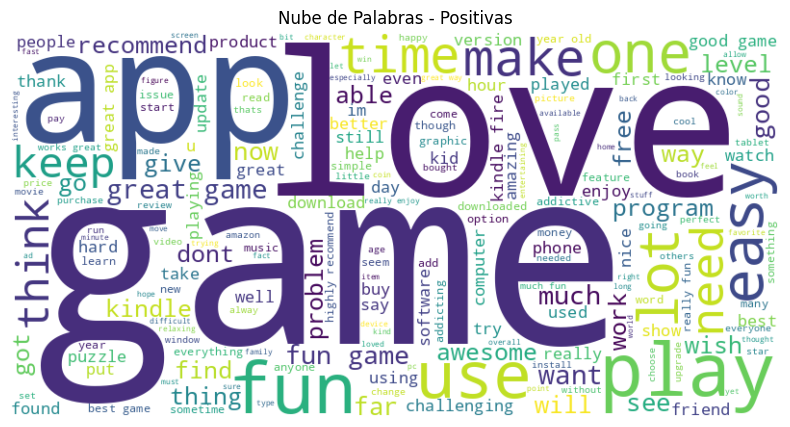

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Crear sesi√≥n de Spark
spark = SparkSession.builder.appName("NubeDePalabras").getOrCreate()

# Cargar dataset procesado
df = spark.read.parquet("data/processed/Software_processed.parquet")

# Convertir a Pandas para visualizaci√≥n
df_pandas = df.select("text", "label").toPandas()

# Generar nubes de palabras para positivos y negativos
for label in [0, 1]:
    text_data = " ".join(df_pandas[df_pandas["label"] == label]["text"])

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nube de Palabras - {'Negativas' if label == 0 else 'Positivas'}")
    plt.show()


üìä **An√°lisis Exploratorio - Nube de Palabras**

Como parte del an√°lisis exploratorio de datos (EDA), se generon nubes de palabras para las clases de rese√±as positivas y negativas, con el fin de identificar patrones ling√º√≠sticos relevantes.

* üìå **Preprocesamiento:** Antes de construir las nubes, los textos fueron sometidos a normalizaci√≥n, incluyendo la conversi√≥n a min√∫sculas, eliminaci√≥n de stopwords, eliminaci√≥n de caracteres especiales y tokenizaci√≥n. Esto asegura que solo se visualicen t√©rminos significativos.

* üìå **Frecuencia de t√©rminos:**
En la clase positiva, las palabras m√°s frecuentes incluyen game, play, fun, love, easy, use, lo que sugiere que los usuarios valoran la jugabilidad y facilidad de uso.
En la clase negativa, destacan work, problem, update, money, install, indicando que las quejas se relacionan con problemas t√©cnicos y costos.

* üìå **Posibles sesgos:** Se observa que algunos t√©rminos aparecen en ambas nubes (game, use, play), lo que podr√≠a generar ambig√ºedad en la clasificaci√≥n. Esto sugiere la necesidad de t√©cnicas como TF-IDF o embeddings para capturar el contexto de las palabras en lugar de solo su frecuencia.

* üìå **Impacto en el modelo:** Este an√°lisis respalda la importancia de t√©cnicas de representaci√≥n como Word2Vec, TF-IDF o BERT para capturar mejor los matices en el significado de las palabras. Adem√°s, permite evaluar si el balanceo de clases ha generado p√©rdida de informaci√≥n relevante en el dataset.

In [ ]:
print(df.show())

+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+-----+
|      asin|helpful_vote|images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|label|
+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+-----+
|B06XW6RFV2|          38|    []| B06XW6RFV2|   1.0|                  1 |1492261436000|‚ì¢‚ìû ‚ì¢‚ì£‚ì§‚ìü‚ìò‚ìì ‚ìì‚ìû‚ìù'‚ì£ ‚ìñ...|AEBCICFZOHMXJQN5D...|             true|    0|
|B019DCHDZK|           0|    []| B019DCHDZK|   1.0| 6300 a month on ...|1617545629074|       too expensive|AFNRECJDZ6HSZ5YJM...|             true|    0|
|B007TAX5D8|           2|    []| B007TAX5D8|   2.0| being the free v...|1443469885000|TOO MANY LOCKED L...|AESEQWCUBNZ7TAYQL...|             true|    0|
|B0124YIKY2|          11|    []| B0124YIKY2|   1.0| but 

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Crear sesi√≥n de Spark
spark = SparkSession.builder.appName("NubeDePalabras").getOrCreate()

# Cargar dataset procesado
df = spark.read.parquet("data/processed/Software_processed.parquet")

# Convertir a Pandas para visualizaci√≥n
df_pandas = df.select("text", "label").toPandas()

In [ ]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1618854 entries, 0 to 1618853
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1618854 non-null  object
 1   label   1618854 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 18.5+ MB


1Ô∏è‚É£ An√°lisis de Distribuci√≥n

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_text_length(df, text_column="text"):
    """Analiza la distribuci√≥n de la longitud de los textos."""
    df["text_length"] = df[text_column].apply(lambda x: len(x.split()))

    plt.figure(figsize=(8, 5))
    sns.histplot(df["text_length"], bins=50, kde=True)
    plt.xlabel("Longitud del texto (n√∫mero de palabras)")
    plt.ylabel("Frecuencia")
    plt.title("Distribuci√≥n de la longitud de los textos")
    plt.show()

    return df["text_length"].describe()

def analyze_class_distribution(df, label_column="label"):
    """Muestra la distribuci√≥n de clases en el dataset."""
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=label_column, palette="coolwarm")
    plt.xlabel("Clase")
    plt.ylabel("Frecuencia")
    plt.title("Distribuci√≥n de Clases en el Dataset")
    plt.show()

    return df[label_column].value_counts(normalize=True)



In [ ]:
type(df)

pyspark.sql.dataframe.DataFrame

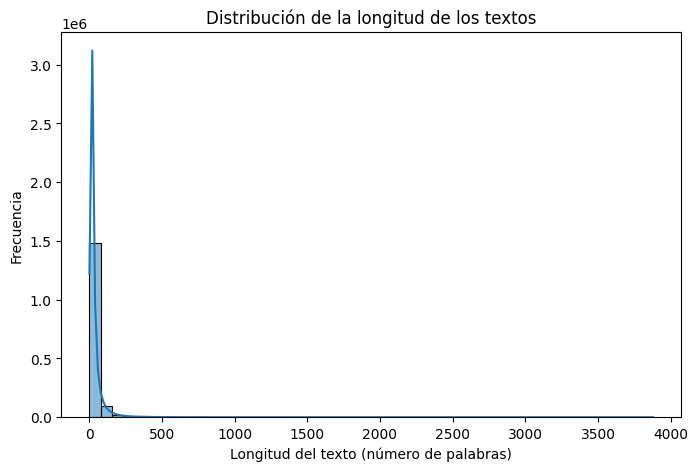


üìä Estad√≠sticas de la longitud de los textos:
 count    1.618854e+06
mean     3.455869e+01
std      5.495737e+01
min      1.000000e+00
25%      1.100000e+01
50%      2.200000e+01
75%      3.700000e+01
max      3.879000e+03
Name: text_length, dtype: float64


<ipython-input-12-959ebb7b3454>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=label_column, palette="coolwarm")


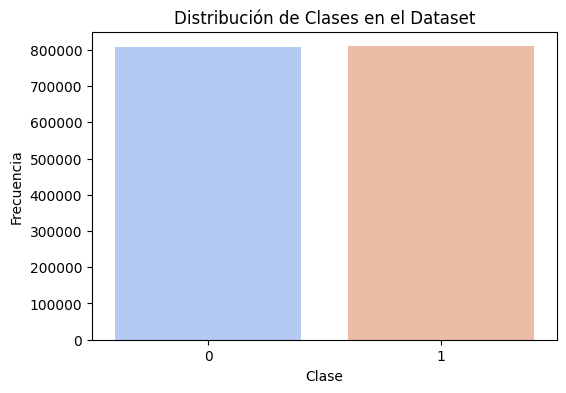


üìä Distribuci√≥n de clases en el dataset:
 label
1    0.500232
0    0.499768
Name: proportion, dtype: float64


In [ ]:
# Analizar la longitud de los textos
text_length_stats = analyze_text_length(df_pandas, text_column="text")
print("\nüìä Estad√≠sticas de la longitud de los textos:\n", text_length_stats)

# Analizar la distribuci√≥n de clases
class_distribution = analyze_class_distribution(df_pandas, label_column="label")
print("\nüìä Distribuci√≥n de clases en el dataset:\n", class_distribution)


2Ô∏è‚É£ An√°lisis Ling√º√≠stico


In [ ]:
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt_tab')

def generate_wordcloud(df, text_column="text", label_column="label"):
    """Genera una nube de palabras para cada clase."""
    for label in df[label_column].unique():
        text = " ".join(df[df[label_column] == label][text_column])
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Nube de Palabras - Clase {label}")
        plt.show()

def analyze_ngrams(df, text_column="text", n=2, top_k=20):
    """Analiza los N-gramas m√°s frecuentes en los textos."""
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)
    n_grams = list(ngrams(tokens, n))

    ngram_counts = Counter(n_grams)
    most_common = ngram_counts.most_common(top_k)

    print(f"Top {top_k} {n}-gramas m√°s frecuentes:")
    for gram, count in most_common:
        print(f"{' '.join(gram)}: {count}")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


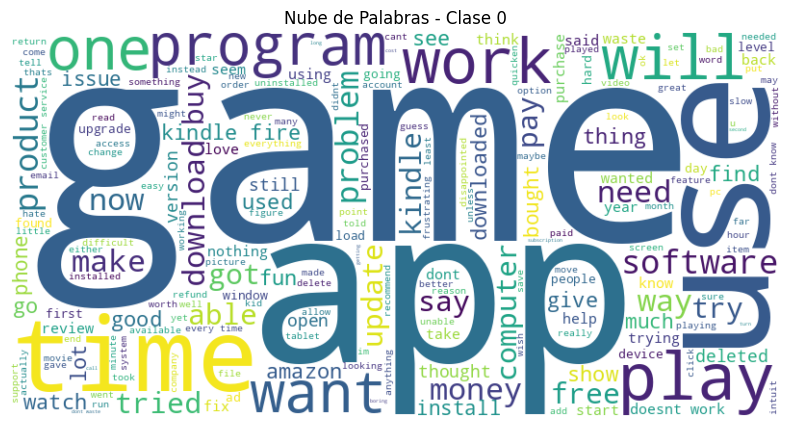

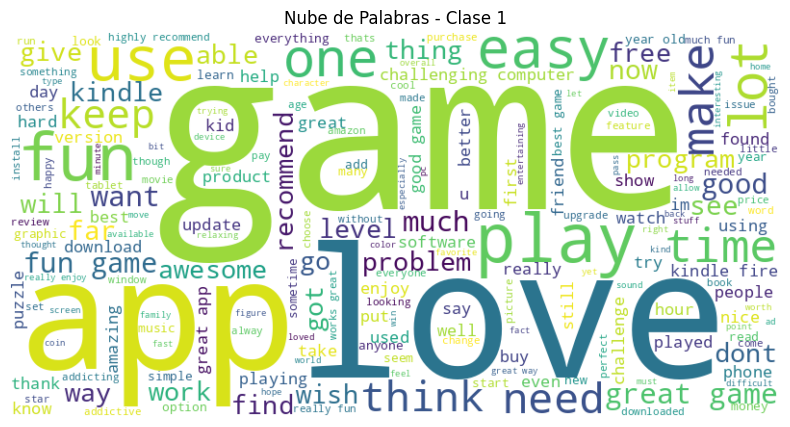

Top 20 2-gramas m√°s frecuentes:
this game: 222812
i have: 171729
it is: 159518
of the: 146552
this app: 140936
this is: 125747
the game: 124825
is a: 113502
on my: 110228
if you: 102084
in the: 100185
have to: 98980
i love: 98376
and i: 96812
to play: 90879
on the: 90429
i am: 84598
to get: 84400
the app: 83199
i was: 82832


In [ ]:
# Generar la nube de palabras por clase
generate_wordcloud(df_pandas, text_column="text", label_column="label")

# Analizar los N-gramas m√°s frecuentes (por ejemplo, bigramas)
analyze_ngrams(df_pandas, text_column="text", n=2, top_k=20)


3Ô∏è‚É£ Detecci√≥n de Posibles Problemas


In [ ]:
from textblob import TextBlob

def analyze_sentiment(df, text_column="text"):
    """Analiza la polaridad y subjetividad de los textos."""
    df["polarity"] = df[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)
    df["subjectivity"] = df[text_column].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.histplot(df["polarity"], bins=50, kde=True, ax=axes[0])
    axes[0].set_title("Distribuci√≥n de la Polaridad")
    axes[0].set_xlabel("Polaridad (de -1 a 1)")

    sns.histplot(df["subjectivity"], bins=50, kde=True, ax=axes[1])
    axes[1].set_title("Distribuci√≥n de la Subjetividad")
    axes[1].set_xlabel("Subjetividad (de 0 a 1)")

    plt.show()

    return df[["polarity", "subjectivity"]].describe()


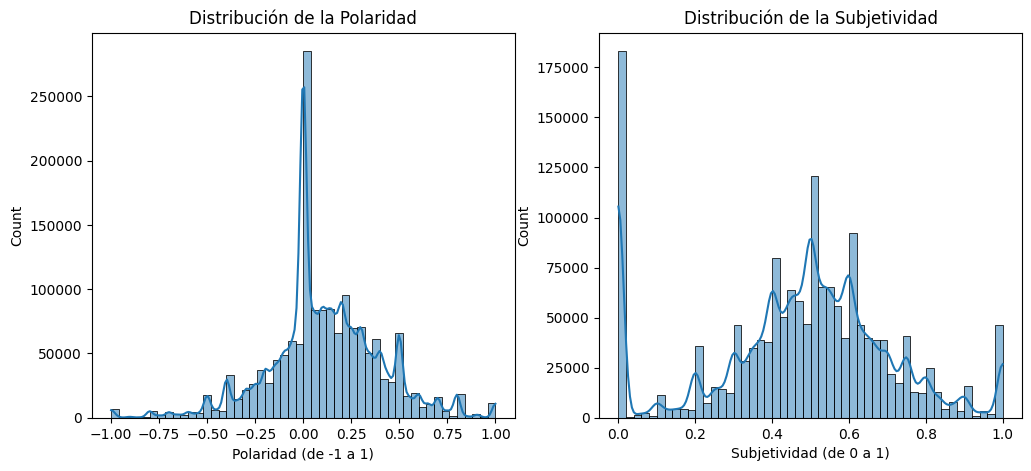


üìä Estad√≠sticas de la polaridad y subjetividad:
            polarity  subjectivity
count  1.618854e+06  1.618854e+06
mean   1.103662e-01  4.710203e-01
std    2.953420e-01  2.418870e-01
min   -1.000000e+00  0.000000e+00
25%   -2.083333e-02  3.541667e-01
50%    8.500000e-02  5.000000e-01
75%    2.923611e-01  6.125000e-01
max    1.000000e+00  1.000000e+00


In [ ]:
# Analizar sentimiento de los textos
sentiment_stats = analyze_sentiment(df_pandas, text_column="text")
print("\nüìä Estad√≠sticas de la polaridad y subjetividad:\n", sentiment_stats)


4Ô∏è‚É£ Validaci√≥n de Preprocesamiento


In [ ]:
def validate_preprocessing(df, text_column="text"):
    """Valida si el dataset est√° correctamente preprocesado."""
    null_count = df[text_column].isnull().sum()
    empty_count = (df[text_column] == "").sum()
    duplicate_count = df.duplicated().sum()

    print(f"üîç Valores nulos en '{text_column}': {null_count}")
    print(f"üîç Registros vac√≠os en '{text_column}': {empty_count}")
    print(f"üîç Duplicados en el dataset: {duplicate_count}")

    return null_count == 0 and empty_count == 0 and duplicate_count == 0


In [ ]:
# Validar si los datos est√°n correctamente preprocesados
is_clean = validate_preprocessing(df_pandas, text_column="text")
if is_clean:
    print("\n‚úÖ El dataset est√° limpio y sin problemas mayores.")
else:
    print("\n‚ö†Ô∏è Se detectaron problemas en el dataset, es necesario revisarlo.")


üîç Valores nulos en 'text': 0
üîç Registros vac√≠os en 'text': 0
üîç Duplicados en el dataset: 0

‚úÖ El dataset est√° limpio y sin problemas mayores.


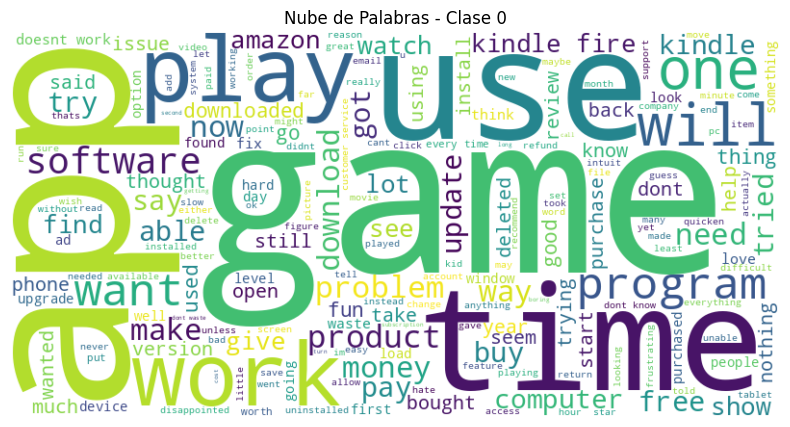

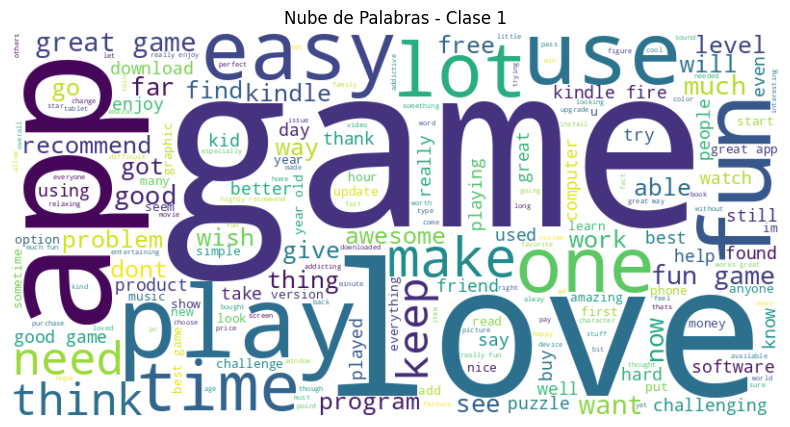

In [ ]:
# Generar la nube de palabras por clase
generate_wordcloud(df_pandas, text_column="text", label_column="label")


**Analizar los N-gramas m√°s frecuentes**

In [ ]:

# Analizar los N-gramas m√°s frecuentes bigramas
analyze_ngrams(df_pandas, text_column="text", n=2, top_k=20)

Top 20 2-gramas m√°s frecuentes:
this game: 222812
i have: 171729
it is: 159518
of the: 146552
this app: 140936
this is: 125747
the game: 124825
is a: 113502
on my: 110228
if you: 102084
in the: 100185
have to: 98980
i love: 98376
and i: 96812
to play: 90879
on the: 90429
i am: 84598
to get: 84400
the app: 83199
i was: 82832


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Crear sesi√≥n de Spark
spark = SparkSession.builder.appName("NubeDePalabras").getOrCreate()

# Cargar dataset procesado
df = spark.read.parquet("data/processed/Software_processed.parquet")

# Convertir a Pandas para visualizaci√≥n
df_pandas = df.select("text", "label").toPandas()

üîç Analizando n-gramas para la clase: 0
* Top 20 2-gramas m√°s frecuentes por clase


In [ ]:


# Crear un diccionario para almacenar los resultados por clase
ngrams_by_class = {}

# Agrupar por la columna de etiqueta y aplicar analyze_ngrams a cada clase
for label, group in df_pandas.groupby("label"):
    print(f"\nüîç Analizando n-gramas para la clase: {label}")
    ngrams_by_class[label] = analyze_ngrams(group, text_column="text", n=2, top_k=20)
    print(ngrams_by_class[label])  # Mostrar resultados por clase


üîç Analizando n-gramas para la clase: 0
Top 20 2-gramas m√°s frecuentes:
i have: 101534
of the: 84907
this app: 78869
this game: 76216
the game: 73410
on my: 70958
it is: 70859
have to: 65392
the app: 65363
in the: 62916
i was: 59017
on the: 57653
if you: 56640
it was: 56456
to the: 53932
to get: 53798
this is: 53257
to be: 52249
and i: 51225
i am: 49235
None

üîç Analizando n-gramas para la clase: 1
Top 20 2-gramas m√°s frecuentes:
this game: 146596
it is: 88659
i love: 87641
this is: 72490
i have: 70195
is a: 69236
this app: 62067
of the: 61645
game is: 53383
to play: 52019
the game: 51415
love this: 48888
easy to: 48808
you can: 48033
and i: 45587
if you: 45444
i like: 42164
love it: 41872
on my: 39270
in the: 37269
None


üîç  Diferencias clave entre las clases
Sentimiento positivo en la Clase 1

* Frases como "i love", "love this", "love it" indican opiniones positivas.
Tambi√©n destacan expresiones como "easy to" y "to play", lo que sugiere que los usuarios encuentran la app o juego intuitivo y entretenido.
"game is" aparece con alta frecuencia, lo que indica que los comentarios est√°n enfocados en la experiencia del juego.
Tonos m√°s neutros o negativos en la Clase 0

* Frases como "i have", "this app", "this game" aparecen en ambas clases, pero sin connotaciones emocionales fuertes en la Clase 0.
"have to" y "to get" pueden sugerir requisitos o frustraciones (por ejemplo, "have to pay", "have to wait").
"it was", "i was" y "to be" sugieren descripciones de experiencias, posiblemente reflejando insatisfacci√≥n.
Palabras compartidas entre ambas clases

* Frases como "this game", "this app", "i have", "it is", "in the", "of the", "on my", "if you", "to be" son comunes en ambas, pero su contexto en cada comentario podr√≠a diferenciar su carga emocional.


In [ ]:
print(ngrams_by_class)

{0: None, 1: None}


In [ ]:
!pip install fasttext

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 73.4/73.4 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313502 sha256=d1ec01b93a1f5ea6916c075939ee88426abb92b13cb503fdb32b3534cf49358b
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -P models/


--2025-03-20 00:27:32--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.34.53, 13.226.34.7, 13.226.34.83, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.34.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‚Äòmodels/lid.176.bin‚Äô

lid.176.bin         100%[===================>] 125.18M   159MB/s    in 0.8s    

2025-03-20 00:27:33 (159 MB/s) - ‚Äòmodels/lid.176.bin‚Äô saved [131266198/131266198]



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
import fasttext
import numpy as np  # Import NumPy
file_path = "data/models/lid.176.bin"

model = fasttext.load_model(file_path)  # Cargar modelo en cada worker

def detect_language(text):
    if not text:
        return "unknown"  # Evita errores si `text` es None
    label= model.predict([text.replace("\n", " ")])
    return label[0][0][0].replace("__label__", "")

# 3Ô∏è‚É£ Crear la UDF en PySpark
detect_language_udf = udf(detect_language, StringType())

# 4Ô∏è‚É£ Cargar dataset procesado
df = spark.read.parquet("data/processed/Software_processed.parquet")

# # 5Ô∏è‚É£ Aplicar la detecci√≥n de idioma
df = df.withColumn("language", detect_language_udf(col("text")))
print(df.columns)  # Verifica si la columna "language" fue agregada
df.show(20, truncate=True)


['asin', 'helpful_vote', 'images', 'parent_asin', 'rating', 'text', 'timestamp', 'title', 'user_id', 'verified_purchase', 'label', 'language']
+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+-----+--------+
|      asin|helpful_vote|images|parent_asin|rating|                text|    timestamp|               title|             user_id|verified_purchase|label|language|
+----------+------------+------+-----------+------+--------------------+-------------+--------------------+--------------------+-----------------+-----+--------+
|B06XW6RFV2|          38|    []| B06XW6RFV2|   1.0|                  1 |1492261436000|‚ì¢‚ìû ‚ì¢‚ì£‚ì§‚ìü‚ìò‚ìì ‚ìì‚ìû‚ìù'‚ì£ ‚ìñ...|AEBCICFZOHMXJQN5D...|             true|    0|      en|
|B019DCHDZK|           0|    []| B019DCHDZK|   1.0| 6300 a month on ...|1617545629074|       too expensive|AFNRECJDZ6HSZ5YJM...|             true|    0|      en|
|B007TAX5D8|         